# Filippo Galli's Notebook
This notebook contains code related to sequence alignments and parameter inference using SBI (Simulation-Based Inference). It includes data loading with the DataLoader, model training, and posterior sampling steps.

In [1]:
from teddy.lightning.datamodule import BDS_datamodule
import teddy.data.Alphabet as alphabet
from copy import deepcopy
from sbi.inference.posteriors import DirectPosterior
from sbi.utils import BoxUniform

import torch
from torch.optim import Adam
import gc

from sbi.analysis import pairplot
import matplotlib.pyplot as plt

from sbi.neural_nets.net_builders import build_nsf
from sbi.neural_nets.embedding_nets import CausalCNNEmbedding
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lower_bound = torch.as_tensor([1.0, 1.0, 10**(-2), 10**(-5), 0.0])
upper_bound = torch.as_tensor([5.0, 10.0, 1, 10**(-2), 100.0])
prior = BoxUniform(low=lower_bound, high=upper_bound)

alphabet_instance = alphabet.Alphabet(list( "ATGCX-"))

train_ratio = 0.8
batch_size = 256
val_batch_size = batch_size
num_workers = 8  # Parallel data loading workers

# Define training params
learning_rate = 5e-4
stop_after_epochs = 5  # Stop training after 5 epochs with no improvement
max_num_epochs = 2**31 - 1

/home/vitor/Desktop/Projects/SBI HACKATHON 2026/applied-project/models/sequence-alignments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setting up Density Estimator Network

This section create a density estimator network using a Causal CNN embedding, the Neural density estimator and the DataLoader class BDS_datamodule.

> Here the batch size is set to 1 to enable the possibility to extract from the posterior conditioned on single observations.

In [2]:
# Density estimator with first sequence and prior just for the dimensionality
torch.manual_seed(0)

# To correctly setup the density estimator, we need to pass a batch of data of 1
data = BDS_datamodule(data_dir = "data/example/seq", 
                      alphabet=alphabet_instance, 
                      limit_size=200,
                      max_sites_len=200,
                      train_ratio=train_ratio, 
                      val_batch_size=1, 
                      batch_size=1,
                      num_workers=1,
                      prefetch_factor=1,
                      persistent_workers=False, 
                      pin_memory=False)

data.setup()

train_loader = data.train_dataloader()
val_loader = data.val_dataloader()

train_iter = iter(train_loader)
batch = next(train_iter)

x_batch = batch[0].to(device) # [batch_size, 20520]
theta_batch = batch[1].to(device) # [batch_size, 2]

embedding_net = CausalCNNEmbedding(  # SOLUTION
    input_shape=(batch[0].shape[1],),  # 20000 timepoints
    in_channels=1,  # 1 channel: sequence data
    output_dim=20,  # Compress to 20 learned summary features
    num_conv_layers=5,  # Number of dilated causal conv layers
    kernel_size=2,  # Kernel size for convolutions
)

density_estimator = build_nsf(
    theta_batch,
    x_batch,
    z_score_y="none",
    z_score_x="none",
    embedding_net=embedding_net,
).to(device)  # theta batch dimension, x batch dimension

data/example/design.csv
a
(16, 127)
(64, 63)
(20, 31)


# Training Loop 

In [5]:
# Data Loader parallelization
data_train = BDS_datamodule(data_dir = "data/example/seq", 
                      alphabet=alphabet_instance, 
                      limit_size=200,
                      max_sites_len=200,
                      train_ratio=train_ratio, 
                      val_batch_size=batch_size, 
                      batch_size=batch_size,
                      num_workers=num_workers,
                      prefetch_factor=1,
                      persistent_workers=False, 
                      pin_memory=False, 
                      cache_dir = "data/cache")
data_train.setup()

train_loader_train = data_train.train_dataloader()
val_loader_train = data_train.val_dataloader()


optimizer = Adam(list(density_estimator.parameters()), lr=learning_rate)

# Clean up initialization batch
# del train_iter, batch, x_batch, theta_batch
gc.collect()

# === OPTIMIZED TRAINING LOOP ===
epoch = 0
best_val_loss = float("Inf")
epochs_since_last_improvement = 0
converged = False

while epoch <= max_num_epochs and not converged:
    # === TRAINING PHASE ===
    density_estimator.train()
    train_loss_sum = 0
    num_train_samples = 0

    for batch_idx, batch in enumerate(train_loader_train):
        # Convert batch data to tensors
        x_batch = batch[0].to(device)
        theta_batch = batch[1].to(device)

        # Forward pass and loss computation
        optimizer.zero_grad()
        train_losses = density_estimator.loss(theta_batch, x_batch)
        train_loss = torch.mean(train_losses)

        # Backward pass
        train_loss.backward()
        optimizer.step()

        # Track metrics
        train_loss_sum += train_losses.sum().item()
        num_train_samples += theta_batch.size(0)

        # CRITICAL: Immediate cleanup after each batch
        del x_batch, theta_batch, train_losses, train_loss

        # Periodic garbage collection during training
        if batch_idx % 10 == 0:
            gc.collect()

    epoch += 1
    train_loss_average = train_loss_sum / num_train_samples

    # === VALIDATION PHASE ===
    density_estimator.eval()
    val_loss_sum = 0
    num_val_samples = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader_train):
            x_batch = batch[0].to(device)
            theta_batch = batch[1].to(device)

            val_losses = density_estimator.loss(theta_batch, x_batch)
            val_loss_sum += val_losses.sum().item()
            num_val_samples += theta_batch.size(0)

            # Immediate cleanup
            del x_batch, theta_batch, val_losses

            if batch_idx % 5 == 0:
                gc.collect()

    val_loss = val_loss_sum / num_val_samples

    # === MODEL CHECKPOINTING ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_since_last_improvement = 0
        # Store only state dict, not entire model
        best_model_state_dict = deepcopy(density_estimator.state_dict())
    else:
        epochs_since_last_improvement += 1

    # === CONVERGENCE CHECK ===
    if epochs_since_last_improvement > stop_after_epochs - 1:
        density_estimator.load_state_dict(best_model_state_dict)
        converged = True
        print(f"\nNeural network successfully converged after {epoch} epochs")
    else:
        print(
            f"Epoch {epoch}: Train loss: {train_loss_average:.4f}, Val loss: {val_loss:.4f}, Stops in: {stop_after_epochs - epochs_since_last_improvement}'"
        )

    # Force garbage collection after each epoch
    gc.collect()

# === POST-TRAINING CLEANUP ===
print("\nCleaning up training resources...")

# Delete dataloaders to free worker memory
gc.collect()

# Optional: If using CUDA, clear GPU cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Training complete and memory cleaned!")

data/example/design.csv
a
Epoch 1: Train loss: 123.1180, Val loss: 128.2572, Stops in: 5'
Epoch 2: Train loss: 119.0970, Val loss: 124.7745, Stops in: 5'
Epoch 3: Train loss: 115.7857, Val loss: 121.3122, Stops in: 5'
Epoch 4: Train loss: 112.5502, Val loss: 118.2924, Stops in: 5'
Epoch 5: Train loss: 109.6948, Val loss: 115.3548, Stops in: 5'
Epoch 6: Train loss: 106.9431, Val loss: 112.5410, Stops in: 5'
Epoch 7: Train loss: 104.3414, Val loss: 110.0433, Stops in: 5'
Epoch 8: Train loss: 101.8938, Val loss: 107.8342, Stops in: 5'
Epoch 9: Train loss: 99.6272, Val loss: 105.1747, Stops in: 5'
Epoch 10: Train loss: 97.2223, Val loss: 102.8934, Stops in: 5'
Epoch 11: Train loss: 95.0300, Val loss: 100.1952, Stops in: 5'
Epoch 12: Train loss: 92.7634, Val loss: 98.5870, Stops in: 5'
Epoch 13: Train loss: 91.0679, Val loss: 96.2556, Stops in: 5'
Epoch 14: Train loss: 88.9544, Val loss: 94.4746, Stops in: 5'
Epoch 15: Train loss: 87.1499, Val loss: 91.7703, Stops in: 5'
Epoch 16: Train los

# Create posterior object

In [16]:
posterior = DirectPosterior(density_estimator, prior)
posterior.to("cpu")

# Testing with training data

x_o shape: torch.Size([1, 20402]), theta_o shape: torch.Size([1, 5])




/home/vitor/Desktop/Projects/SBI HACKATHON 2026/applied-project/models/sequence-alignments/.venv/lib/python3.11/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2190.)
  outputs, _ = torch.triangular_solve(




10193it [00:00, 40554.45it/s]                          
/tmp/ipykernel_365998/1880456717.py:14: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


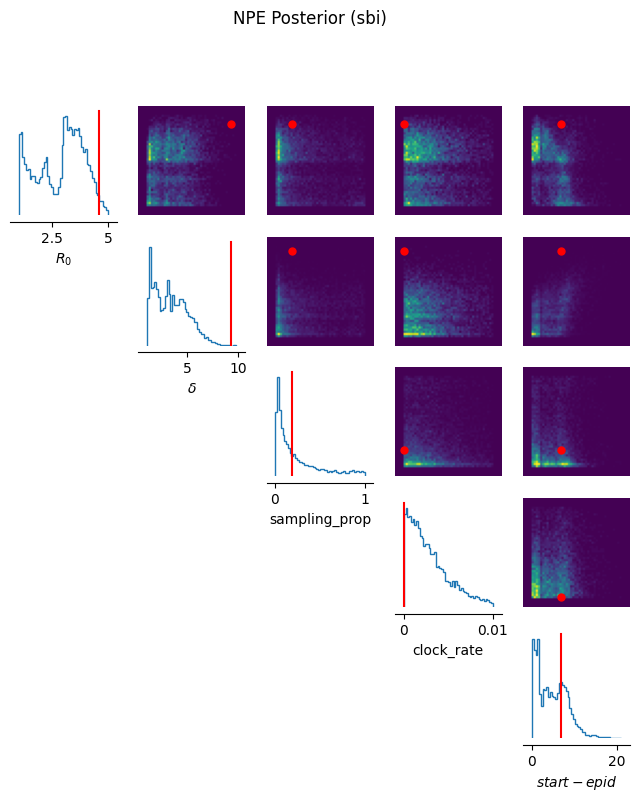

In [17]:
train_iter = iter(train_loader)
batch = next(train_iter)

x_o = batch[0].cpu()
theta_o = batch[1].cpu()

print(f"x_o shape: {x_o.shape}, theta_o shape: {theta_o.shape}")

samples = posterior.sample((10000,), x=x_o)

# Visualize posterior with pairplot
param_labels = [r"$R_0$", r"$\delta$", "sampling_prop", "clock_rate",  r"$start-epid$"]

fig, axes = pairplot(
    samples,
    # limits=[[0.05, 0.15], [0.01, 0.03], [0.005, 0.03], [0.005, 0.15]],
    labels=param_labels,
    figsize=(8, 8),
    points=theta_o,  # True parameters
    points_colors="r",
)
plt.suptitle("NPE Posterior (sbi)", y=1.02)
plt.show()

# Testing with validation data





10327it [00:00, 50668.74it/s]                          
/tmp/ipykernel_365998/3060103810.py:12: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


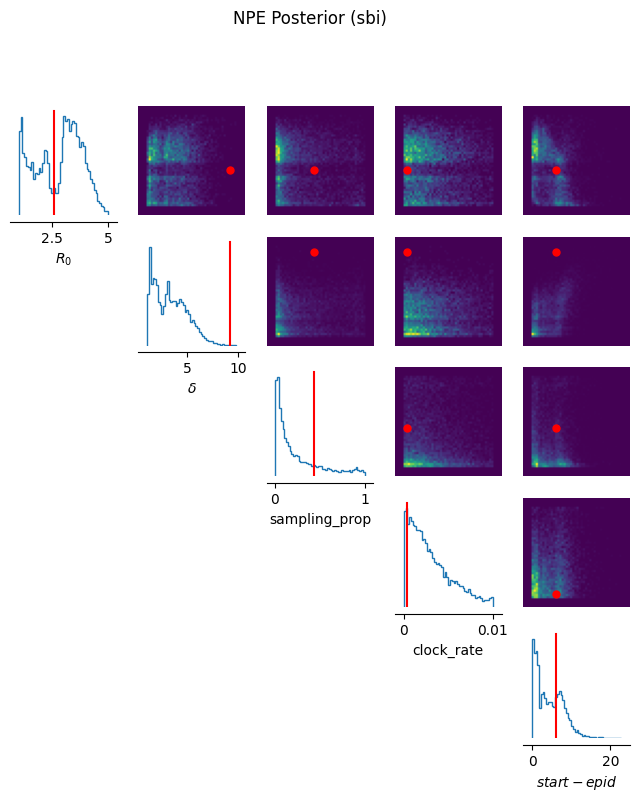

In [18]:
val_iter = iter(val_loader)
for item in val_iter:
    if(item[1][0][0] > 2):
        batch = item
        break

x_o = batch[0]
theta_o = batch[1]

samples = posterior.sample((10000,), x=x_o)

fig, axes = pairplot(
    samples,
    #limits=[[0.05, 0.15], [0.01, 0.03], [0.005, 0.03], [0.005, 0.15]],
    labels=param_labels,
    figsize=(8, 8),
    points=theta_o,  # True parameters
    points_colors="r",
)
plt.suptitle("NPE Posterior (sbi)", y=1.02)
plt.show()